In [5]:
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore.document import Document
from langchain.chains import LLMChain
from langchain.llms import OpenAI
import matplotlib.pyplot as plt
import opendatasets as od
from path import Path
import pandas as pd
import numpy as np
import hdbscan
import pickle
import faiss
import umap

In [6]:
# Uncomment if first time running
# !pip install -r requirements.txt
# od.download("https://www.kaggle.com/datasets/benjaminawd/new-york-times-articles-comments-2020")

# Berine Sanders Experiment

This is an experiment in clustering opinions using embeddings, and feeding these clusters to LLMs so you can converse with a political stance.

Dataset can be found here: https://www.kaggle.com/datasets/benjaminawd/new-york-times-articles-comments-2020

# Prepare Data

In [7]:
df_comments = pd.read_csv('nyt_archive/nyt-comments-2020.csv')

/var/folders/9x/35_l20zd4s5500zk7f2_r9lr0000gn/T/ipykernel_65097/2067877993.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('nyt_archive/nyt-comments-2020.csv')


In [8]:
df_articles = pd.read_csv('nyt_archive/nyt-articles-2020.csv')

In [9]:
# find articleID with most comments
most_common = df_comments['articleID'].value_counts()

# Most popular article is some special interaction article and won't be useful for our purposes
# Get the ID for the second most popular article - one about Bernie Sanders
article_id = most_common.index[1]

In [10]:
article = df_articles[df_articles['uniqueID'] == article_id]
print(article['headline'].values[0])
print(article['abstract'].values[0])

Bernie Sanders Is Making a Big Mistake
It has to do with respect.


In [11]:
comments = df_comments[df_comments['articleID'] == article_id]
# Only include top-level comments
comments = comments[comments['parentID'].isnull()]
comments

,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,commentBody,createDate,updateDate,...,editorsSelection,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,articleID
782620,105398457,approved,105398457,72035088,Robert,chicago,NaN,"It’s not about this election, it’s about joini...",2020-02-23 23:53:44,2020-03-01 22:46:41,...,False,NaN,NaN,1,comment,0,0,105398457,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
782643,105398489,approved,105398489,95731640,Bronx Jon,NYC,NaN,That’s quite a stretch to think that Sanders w...,2020-02-23 23:56:20,2020-02-24 16:52:25,...,False,NaN,NaN,1,comment,0,0,105398489,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
782648,105398504,approved,105398504,36546429,Joe Mancini,Fredericksburg VA,NaN,"If you are a Never Trump Republican, there are...",2020-02-23 23:58:20,2020-03-01 22:13:21,...,False,NaN,NaN,1,comment,0,0,105398504,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
782651,105398534,approved,105398534,52422067,Jess,Salt Lake City,NaN,"If democrats nominate Sanders, Trump will be a...",2020-02-24 00:01:15,2020-03-01 22:26:59,...,False,NaN,NaN,1,comment,0,0,105398534,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
782667,105398539,approved,105398539,80821232,"who, me?",usa,NaN,"I agree. However, Mr. Sanders, must hammer awa...",2020-02-24 00:01:38,2020-02-24 14:07:03,...,False,NaN,NaN,1,comment,0,0,105398539,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788306,105417593,approved,105417593,104796950,sharon5101,Rockaway Park,NaN,I will never understand what so many voters s...,2020-02-24 20:27:58,2020-03-06 15:32:08,...,False,NaN,NaN,1,comment,0,0,105417593,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
788309,105420426,approved,105420426,69317304,Don Spritzer,Montana,NaN,I love Bernie Sanders and will vote for him wi...,2020-02-24 23:01:00,2020-03-06 15:31:59,...,False,NaN,NaN,1,comment,0,0,105420426,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
788310,105418089,approved,105418089,11593773,new conservative,"new york, ny",NaN,How can you Bernie supporters actually fall fo...,2020-02-24 20:53:32,2020-03-06 15:31:20,...,False,NaN,NaN,1,comment,0,0,105418089,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...
788311,105417781,approved,105417781,66722644,Jose,NYC,NaN,I consider myself an Independent and not a Tru...,2020-02-24 20:37:44,2020-03-03 13:27:18,...,False,NaN,NaN,1,comment,0,0,105417781,False,nyt://article/57736deb-c3d4-5640-8732-bce6442e...


In [12]:
def chars_to_tokens(chars: int):
    return round(chars / 6 * 0.7) # very rough estimate: 6 chars per word, 0.7 tokens per word

price_per_token = 0.0004 / 1000
cost = comments['commentBody'].apply(len).apply(chars_to_tokens).mean() * price_per_token * len(comments)
print(f"Cost for OpenAI emebeddings is roughly: ${cost.round(3)}")

Cost for OpenAI emebeddings is roughly: $0.065


In [13]:
price_per_token = 0.0004 / 1000
cost = comments['commentBody'].apply(len).apply(chars_to_tokens).mean() * price_per_token * len(comments)
print(f"Cost for embeddings is roughly: ${cost}")

Cost for embeddings is roughly: $0.065054


In [14]:
comments['commentBody'].apply(len).apply(chars_to_tokens).describe() 

count    2632.000000
mean       61.791413
std        45.009060
min         1.000000
25%        27.000000
50%        51.000000
75%        84.000000
max       215.000000
Name: commentBody, dtype: float64

Max ~215 tokens for longest comment, fits well within embedding model context window. No need to use a text splitter.

In [15]:
%%time

class StopExecution(Exception):
    """For quietly stopping execution of a cell"""
    def _render_traceback_(self):
        pass

embeddings = []

# Create output folder if it doesn't exist
if not Path("./output").exists():
    Path("./output").mkdir()

# Get the embeddings from disk if they exist.
emb_path = Path(f"./output/embeddings_{article_id.replace('nyt://article/', '')}.pkl")
if emb_path.exists():
    with open(emb_path, "rb") as f:
        embeddings = pickle.load(f)
        embeddings = np.asarray(embeddings)
        raise StopExecution()

# Otherwise, compute them.
texts = comments['commentBody'].tolist()
metadatas = [{"source": cid} for cid in comments['commentID'].tolist()]
print(f"Embedding {len(texts)} documents...")
embeddings = OpenAIEmbeddings().embed_documents(texts)
embeddings = np.asarray(embeddings)
with open(emb_path, "wb") as f:
    pickle.dump(embeddings, f)

# Cluster Embeddings with UMAP + HDBSCAN

In [293]:
%%time

# Reduce dimensionality
reducer = umap.UMAP(n_components=3, random_state=1337)
embeddings_reduced = reducer.fit_transform(embeddings)

# Fit HDBSCAN to data with reduced dimensionality
clusterer = hdbscan.HDBSCAN(min_cluster_size=32, gen_min_span_tree=True)
clusterer.fit(embeddings_reduced)

CPU times: user 11.6 s, sys: 465 ms, total: 12 s
Wall time: 11.3 s


HDBSCAN(gen_min_span_tree=True, min_cluster_size=32)

In [294]:
print(f"{clusterer.labels_.max() + 1} clusters found") # +1 because -1 is the noise cluster, starts at 0

10 clusters found


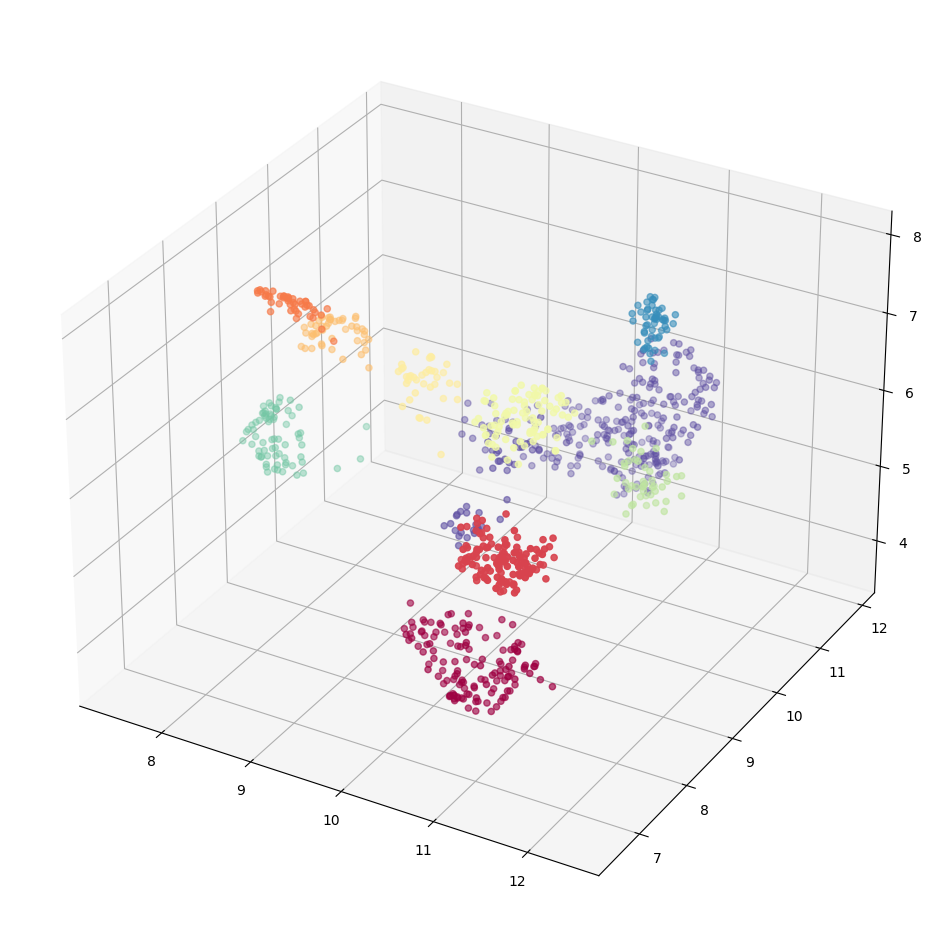

In [295]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = embeddings_reduced[:,0], embeddings_reduced[:,1], embeddings_reduced[:,2]
colors = [c if c != -1 else None for c in clusterer.labels_]
plt.scatter(x=X, y=Y, zs=Z, c=colors, cmap='Spectral', s=20)
plt.show()

Get representative samples for each cluster by taking the mean of each cluster

In [253]:
# How many samples per cluster
k = 5

# Find the center of each cluster by taking the mean of its consitutent embeddings
unique_labels = [l for l in np.unique(clusterer.labels_) if l != -1]
centers = []
for label in unique_labels:
    indices = np.where(clusterer.labels_ == label)[0]
    cluster = np.take(embeddings_reduced, indices, axis=0)
    centers.append((label, np.mean(cluster, axis=0)))

# Find the k embeddings closest to the center of each cluster
k_closest = []
for i, (_, center) in enumerate(centers):
    distances = np.linalg.norm(embeddings_reduced - center, axis=1)
    indices = np.argpartition(distances, k)[:k]
    k_closest.append(indices)

### Sanity check cluster representatives

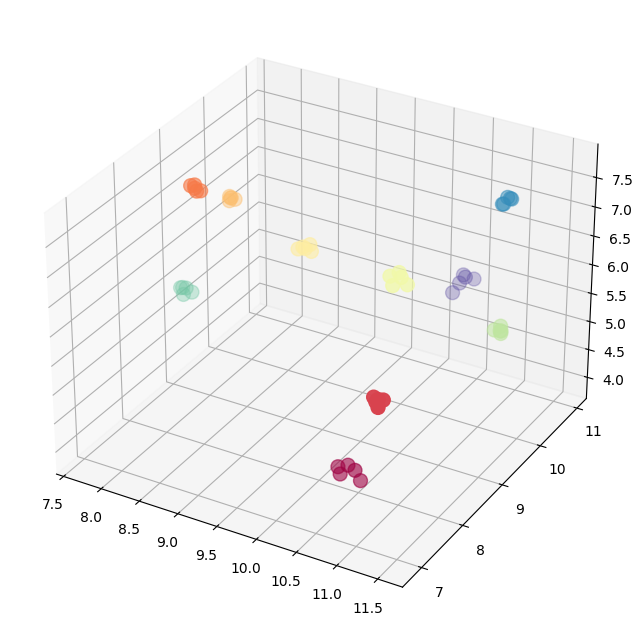

In [255]:
all_closest = np.asarray([embeddings_reduced[i] for i in np.concatenate(k_closest).tolist()])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
X, Y, Z = all_closest[:,0], all_closest[:,1], all_closest[:,2]
colors = [math.floor(i / k) for i in range(len(all_closest))]
plt.scatter(x=X, y=Y, zs=Z, c=colors, cmap='Spectral', s=100)
plt.show()


In [289]:
from typing import List

summary_prompt = """Summarize the author's belief about Bernie Sanders from the following texts that they have written:

TEXTS:
{text}


CONCISE SUMMARY:"""

def summarize_texts(comments: List[str]):
    PROMPT = PromptTemplate(template=summary_prompt, input_variables=["text"])
    chain = load_summarize_chain(OpenAI(temperature=0), chain_type="stuff", prompt=PROMPT)
    docs = [Document(page_content=c) for c in comments]
    return chain.run(docs)

In [290]:

summaries = []

for c, r in enumerate(k_closest):
    cluster_comments = [comments['commentBody'].iloc[i] for i in r]
    summary = summarize_texts(cluster_comments)
    summaries.append(summary)
    print(f"Cluster {c}: {summary}")

Cluster 0: 
The author believes that Bernie Sanders shows respect for people who disagree with him by being honest and not pandering to them. He also believes that Sanders is signaling respect to voters outside of his base by redirecting the conversation to be about the interests of everyday Americans, and not engaging in tribal or identity politics. Sanders is trying to update the US welfare system to come in line with the rest of the western world, and the author believes that this is a sign of respect for all voters.
Cluster 1: 
The author believes that Bernie Sanders is building an impressive coalition of people from all political backgrounds, and that the New York Times has been unfairly biased against him. They criticize the Times for their "hit pieces" and "Sanders bashing" and suggest that they are corporate shills.
Cluster 2: 
The author believes that Bernie Sanders is not making a mistake by advocating for a ban on fracking, as it is a dangerous and resource-draining practice

# LangChain Chatbot For Each Cluster

In [303]:
from typing import Dict, Tuple, Type
import typing
from langchain.chains.base import Chain
from pydantic import BaseModel, Extra
import pandas as pd
from langchain.chains.conversation.memory import ConversationalBufferWindowMemory
from langchain.llms.base import BaseLLM
    

class ClusterChain(LLMChain, BaseModel):
    memory=ConversationalBufferWindowMemory(k=2)

    def __init__(self, comments: str, **kwargs):
        prompt_template = """You are a kind, respectful language model trained to represent views about a political opinion.
    
Your task is to mimic the opinions of a bunch of comments to a news article about Bernie Sanders. When asked about your opinions about the article, answer as if you were the author of the comments. When asked about something unrelated, mention that you don't have an opinion about that.

COMMMENTS
{comments}
END COMMENTS

{history}
Human: {human_input}
Assistant:"""

        kwargs["prompt"] = PromptTemplate(
            input_variables=["history", "human_input"], 
            template=prompt_template.replace("{comments}", comments) 
        )
        super().__init__(**kwargs)

    @property
    def input_keys(self) -> List[str]:
        return ["history", "human_input"]

    @classmethod
    def from_comments(self, comments: str) -> Type["ClusterChain"]:
        return self(comments=comments, llm=OpenAI(temperature=0), verbose=False)


def concat_comments(indices: List[int]) -> str:
    return '\n'.join([comments['commentBody'].iloc[i] for i in indices])

In [304]:
cluster_chains = [ClusterChain.from_comments(concat_comments(idxs.tolist())) for idxs in k_closest]

In [305]:
bernie_needs_to_go_center = cluster_chains[3]
bernie_is_doing_gud = cluster_chains[0]

In [306]:
bernie_needs_to_go_center.run(human_input="What do you think about Bernie Sanders?")

" I think Bernie Sanders has some great ideas that could benefit the country, such as decriminalizing border crossings and providing federal health benefits to undocumented immigrants. However, I think it's important to consider the political realities of the situation and recognize that these policies could be a recipe for disaster for Democrats in a general election. It's important to be mindful of the Electoral College and the Rust Belt when considering progressive policies."

In [307]:
bernie_needs_to_go_center.run("What is dangerous about the policies?")

" I think the danger lies in the fact that these policies could be seen as too extreme by voters in the Rust Belt, who may be more inclined to support more moderate policies. It's important to consider the political realities of the situation and recognize that these policies could be a recipe for disaster for Democrats in a general election."

In [308]:
bernie_is_doing_gud.run(human_input="What do you think about Bernie Sanders?")

' I think Bernie Sanders is a leader who respects people, regardless of their political views. He is honest about his positions and is not afraid to stand up for what he believes in. He is not pandering to anyone, and is instead focused on providing real solutions to the issues facing everyday Americans. He is also willing to listen to those who disagree with him and is open to finding common ground. He is a leader who is focused on the collective good, not just the interests of the wealthy and powerful.'

In [309]:
bernie_is_doing_gud.run(human_input="Some people would argue that Bernie's policies are too radical and may alienate voters. What do you think about that?")

" I think Bernie Sanders' policies are not radical, but rather a necessary step to ensure that all Americans have access to the same opportunities. His policies are designed to benefit everyone, not just the wealthy and powerful. He is not trying to alienate anyone, but rather to bring people together and create a more equitable society. He is not afraid to challenge the status quo and push for real change."

# TODO

- Visualize how clusters of opinions overlap
- Don't just stuff k representative comments in window, use a vectorstore and retrieve